### Q3 BL模型中，观点矩阵特征对模型表现影响研究

Q3研究不同情况下的观点矩阵（正交，非正交等）对BL模型预测未来收益的表现的影响。

#### 1. 研究实现

此测试通过[tool.py](tool.py)中[generate_random_qualified_assets()](tool.py#L143)函数，选取不同的在T时刻(`t_date='20230901'`)后有明显变化的资产。以T时刻后的数据作为未来实际变化情况，根据以下五种逻辑生成对应的观点矩阵P,Q。同时，T时刻前的数据则为BL模型计算中所使用的历史波动。实验以BL模型通过不同的观点矩阵，预测出不同的未来收益。将预测收益和实际收益通过MSE计算比较（[mse_calculation()](tool.py#L388)函数）：

- Orthogonal/Actual: 根据未来实际数据生成的正交对角观点矩阵，即每一行仅代表一个资产的历史变化情况。
- Non-orthogonal: 根据未来实际数据生成的不可正交化的观点矩阵。每行可能包括单独资产的绝对变化情况，或者是两个资产的相对变化情况。
- Orthogonal: 根据未来实际数据生成的正交观点矩阵（经过正交化处理）。每行可能包括单独资产的绝对变化情况，或者是两个资产的相对变化情况。
- Can be orthogonal: 根据未来实际数据生成的可正交化矩阵（未经正交化处理）。每行可能包括单独资产的绝对变化情况，或者是两个资产的相对变化情况。
- Not-related(Random): 随机生成的和未来变化情况冲突的观点矩阵。

#### 2. 测试数据

本实验使用A股（2023年）每日收盘价进行计算，文件位置：[data/AIDX.csv](data/AIDX.csv)

实验过程中随机挑选200种资产组合（数量在5-10只）进行测试。

#### 3. 分析结果概况
- 正交对角观点矩阵（Orthogonal/Actual）的表现最优，BL模型在使用此观点矩阵所计算出的收益最贴近未来实际收益情况。
- 正交观点矩阵 （Orthogonal）的表现位列第二，优于不可正交观点矩阵（Non-orthogonal）和可正交观点矩阵（Can be orthogonal）。

#### 4. 注意事项
- 此实验为自动回测，观点矩阵和资产选择均通过[tool.py](tool.py)中函数自动生成。
- 寻找资产显著变化的函数逻辑在[find_turning_point()](tool.py#L15)函数，可在下方手动调节参数增加对变化趋势的限制。
- 若需要手动输入观点矩阵和资产组合信息，可查看[q3_manual.ipynb](q3_manual.ipynb)。
- 此实验大概需要6分钟完成。

In [1]:
import tool
import pandas as pd
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Data import
"""
asset_index = pd.read_csv("data/AIDX.csv", encoding='gbk')

# data sorting
grouped_asset = asset_index.groupby("S_IRDCODE")
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 200}
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)


In [3]:
"""
Parameter setup
"""

backtest_day = 30
t_date = '20230901' # T, for testing
num_iteration = 200

# (find turning point function) tuning parameters
num_limit = [5,10]
fraction_movement = 0.01
n_days = 7
threshold_day = 22
threshold_rate = 0.05
tolerance_days = 5

In [4]:
"""
Test run
"""

# iteration start
results = []
for i in range(0, num_iteration):
    # initialisation
    asset_info = tool.generate_random_qualified_assets(asset_dfs, num_limit=num_limit, 
                                                       fraction_movement=fraction_movement, threshold_day=threshold_day, n_days=n_days, 
                                                       threshold_rate=threshold_rate, start_date=t_date, tolerance_days=tolerance_days)
    # asset_info = tool.generate_random_assets(asset_dfs)  # random assets without any limitation
    index_list = list(asset_info.keys())
    
    num_assets = len(index_list)
    num_views = num_assets
    
    asset_index_copy = asset_index.copy()
    asset_index_copy['TRADE_DT'] = pd.to_datetime(asset_index_copy['TRADE_DT'], format='%Y%m%d')
    asset_index_copy.sort_values(by='TRADE_DT', inplace=True)
    asset_index_copy.set_index('TRADE_DT', inplace=True)
    asset_index_copy = asset_index_copy.loc[:t_date]
    asset_index_copy = asset_index_copy.pivot(columns='S_IRDCODE', values='CLOSE').ffill()[index_list]
    tmp_close = asset_index_copy.tail(backtest_day)
    
    S = (tmp_close.pct_change().dropna()).cov()
    mcaps = {x:1 for x in list(S.index)}
    delta = 1
    
    try:
        mse_results = tool.mse_calculation(asset_info, S, mcaps, delta, num_assets, num_views)
    except Exception as e:
        print(e)
        continue
    
    results.append(mse_results)

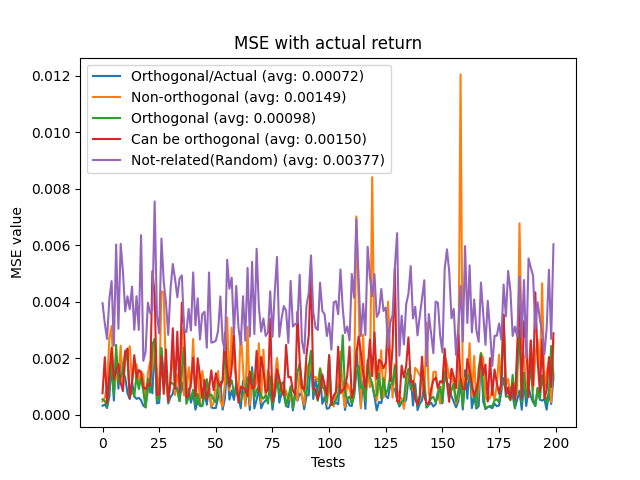

In [5]:
"""
Results output
"""

# visualisation
line_names = ['Orthogonal/Actual', 'Non-orthogonal', 'Orthogonal', 'Can be orthogonal', 'Not-related(Random)']
transposed_list = list(zip(*results))

# Plot each list as a separate line
plt.figure()
for line_data, line_name in zip(transposed_list, line_names):
    avg_value = np.mean(line_data)
    plt.plot(line_data, label=f'{line_name} (avg: {avg_value:.5f})')

# Adding labels and title
plt.xlabel('Tests')
plt.ylabel('MSE value')
plt.title('MSE with actual return')
plt.legend()

# Show the plot
plt.show()

### Q3 实验结果分析

下图为200次随机抽样测试结果，X轴为不同资产组合，Y轴为使用不同观点矩阵的BL模型所预测出的未来收益和未来实际收益的比较值（MSE）。MSE越低，预测收益和实际收益越接近，说明观点矩阵效果越好。在下图可发现，正交对角矩阵的表现最优(0.00072)，其次为正交观点矩阵(0.00098)，低于不可正交矩阵(0.00149)和可正交矩阵(0.00150)。此测试结果验证说明了，在BL模型中，观点矩阵为正交矩阵可以提高BL模型的准确率。

<div style="text-align: left;">
    <img src="img/q3_result.png" style="width: 70%;" />
</div>